# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Introducción</span> <a id=1></a>
Un tumor cerebral es una masa o crecimiento de células anormales en el cerebro. Existen muchos tipos diferentes de tumores cerebrales. Algunos tumores cerebrales no son cancerosos (benignos) y otros son cancerosos (malignos). Los tumores cerebrales pueden comenzar en el cerebro (tumores cerebrales primarios), o en otras partes del cuerpo y extenderse al cerebro como tumores cerebrales secundarios (metastásicos).

La rapidez con que crece un tumor cerebral puede variar mucho. La tasa de crecimiento y la ubicación de un tumor cerebral determinan cómo afectará la función de su sistema nervioso.

Las opciones de tratamiento del tumor cerebral dependen del tipo de tumor cerebral que tenga, así como de su tamaño y ubicación. <br>
**Fuente** : [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084)


<center><img src= "https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2014/10/30/15/17/mcdc7_brain_cancer-8col.jpg" alt ="Brain-MRI" style='width:300px;'></center>


# <span class="list-group-item list-group-item-action active" style="color:red;background-color:white;font-size:22px">Clasificación de imágenes</span> <a id=1.1></a> <br>

El objetivo de este problema de clasificación es identificar a qué categoría corresponden las imágenes cerebrales obtenidas de los pacientes. En este caso, hay distintos tipos de lesiones (glioma, pituitary, meningioma, notumor), y queremos intentar clasificar estas imágenes de manera efectiva según su clase.


In [ ]:
# Cargamos las librerías necesarias

# Librerías del sistema
import os
import itertools

# Librerías para tratar/gestionar datos
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Librerías de aprendizaje automático profundo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Ignoramos los warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Montamos la unidad Drive para acceder a los archivos de Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Especificamos la ruta hasta la carpeta donde tenemos los archivos de la Unidad 5
%cd /content/drive/MyDrive/Colab_Notebooks/Analisis_datos_salud/Unidad5

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/Analisis_datos_salud/Unidad5


# **Cargamos el dataset**


In [ ]:
# Generamos la ruta de las imágenes
train_data_dir = 'data/Brain_images/Training'
filepaths = []
labels = []

# Nos quedamos con el nombre de las carpetas
folds = os.listdir(train_data_dir)

# Iteramos en cada carpeta y identificamos la ruta de las imágenes
# y su categoría (label)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Juntamos la ruta y la categoría de cada imagen en un df
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

# Mostramos el df por pantalla
train_df.head()

,filepaths,labels
0,data/Brain_images/Training/glioma/Tr-gl_0261.jpg,glioma
1,data/Brain_images/Training/glioma/Tr-gl_0715.jpg,glioma
2,data/Brain_images/Training/glioma/Tr-gl_0325.jpg,glioma
3,data/Brain_images/Training/glioma/Tr-gl_0556.jpg,glioma
4,data/Brain_images/Training/glioma/Tr-gl_0285.jpg,glioma


In [ ]:
train_df.labels.unique()

array(['glioma', 'notumor', 'pituitary', 'meningioma'], dtype=object)

In [ ]:
# Repetimos el proceso para el conjunto de test

# Generamos la ruta de las imágenes
train_data_dir = 'data/Brain_images/Testing'
filepaths = []
labels = []

# Nos quedamos con el nombre de las carpetas
folds = os.listdir(train_data_dir)

# Iteramos en cada carpeta y identificamos la ruta de las imágenes
# y su categoría (label)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Juntamos la ruta y la categoría de cada imagen en un df
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)


In [ ]:
# Mostramos el df por pantalla
ts_df.head(5)

,filepaths,labels
0,data/Brain_images/Testing/pituitary/Te-pi_0047...,pituitary
1,data/Brain_images/Testing/pituitary/Te-pi_0126...,pituitary
2,data/Brain_images/Testing/pituitary/Te-pi_0281...,pituitary
3,data/Brain_images/Testing/pituitary/Te-pi_0170...,pituitary
4,data/Brain_images/Testing/pituitary/Te-pi_0097...,pituitary


# **Preproceso de datos**

Primero vamos a mirar si el dataset está balanceado respecto a la categoria `labels`.

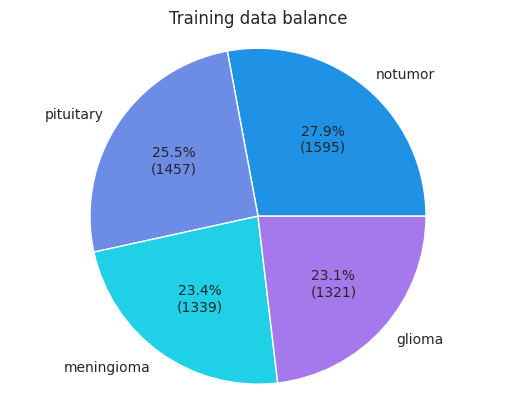

In [ ]:
# Calculamos el número de muestras (imágenes) por categoría
data_balance = train_df.labels.value_counts()


# Creamos un autopct personalizado
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# Mostramos un pie chart con el autopct personalizado
plt.pie(data_balance, labels = data_balance.index,
        autopct=custom_autopct,
        colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

# ¡Podemos ver que el dataset está balanceado!

Ahora vamos a separar los datos de test en conjunto de validación y prueba.

In [ ]:
# Tendremos 50% validación y 50% prueba (test)
valid_df, test_df = train_test_split(
    ts_df,
    train_size= 0.5, shuffle= True, random_state= 42)

**Creación de Image**

Vamos a usar ImageDataGenerator de Keras para generar flujos de datos a partir de datos de pandas, lo que permite cargar y procesar imágenes de manera eficiente para el entrenamiento, validación y prueba de modelos de aprendizaje automático en Keras.

In [ ]:
# Especificamos el batch size y el tamaño de la imagen
batch_size = 16
img_size = (224, 224)

# batch size: número de ejemplos de entrenamiento utilizados en una iteración del algoritmo de entrenamiento.
# Cuando entrenas un modelo de aprendizaje automático, no procesas todos los datos de entrenamiento a la vez,
# ya que esto puede ser computacionalmente costoso y no es eficiente.
# Lo que se hace es dividir los datos de entrenamiento en grupos más pequeños y procesar cada grupo por separado.

# Inicializamos ImageDataGenerator para los datasets de train y test
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Creamos el flujo de datos para los 3 conjuntos de datos (train, validación y test)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


**Imagen del train set**

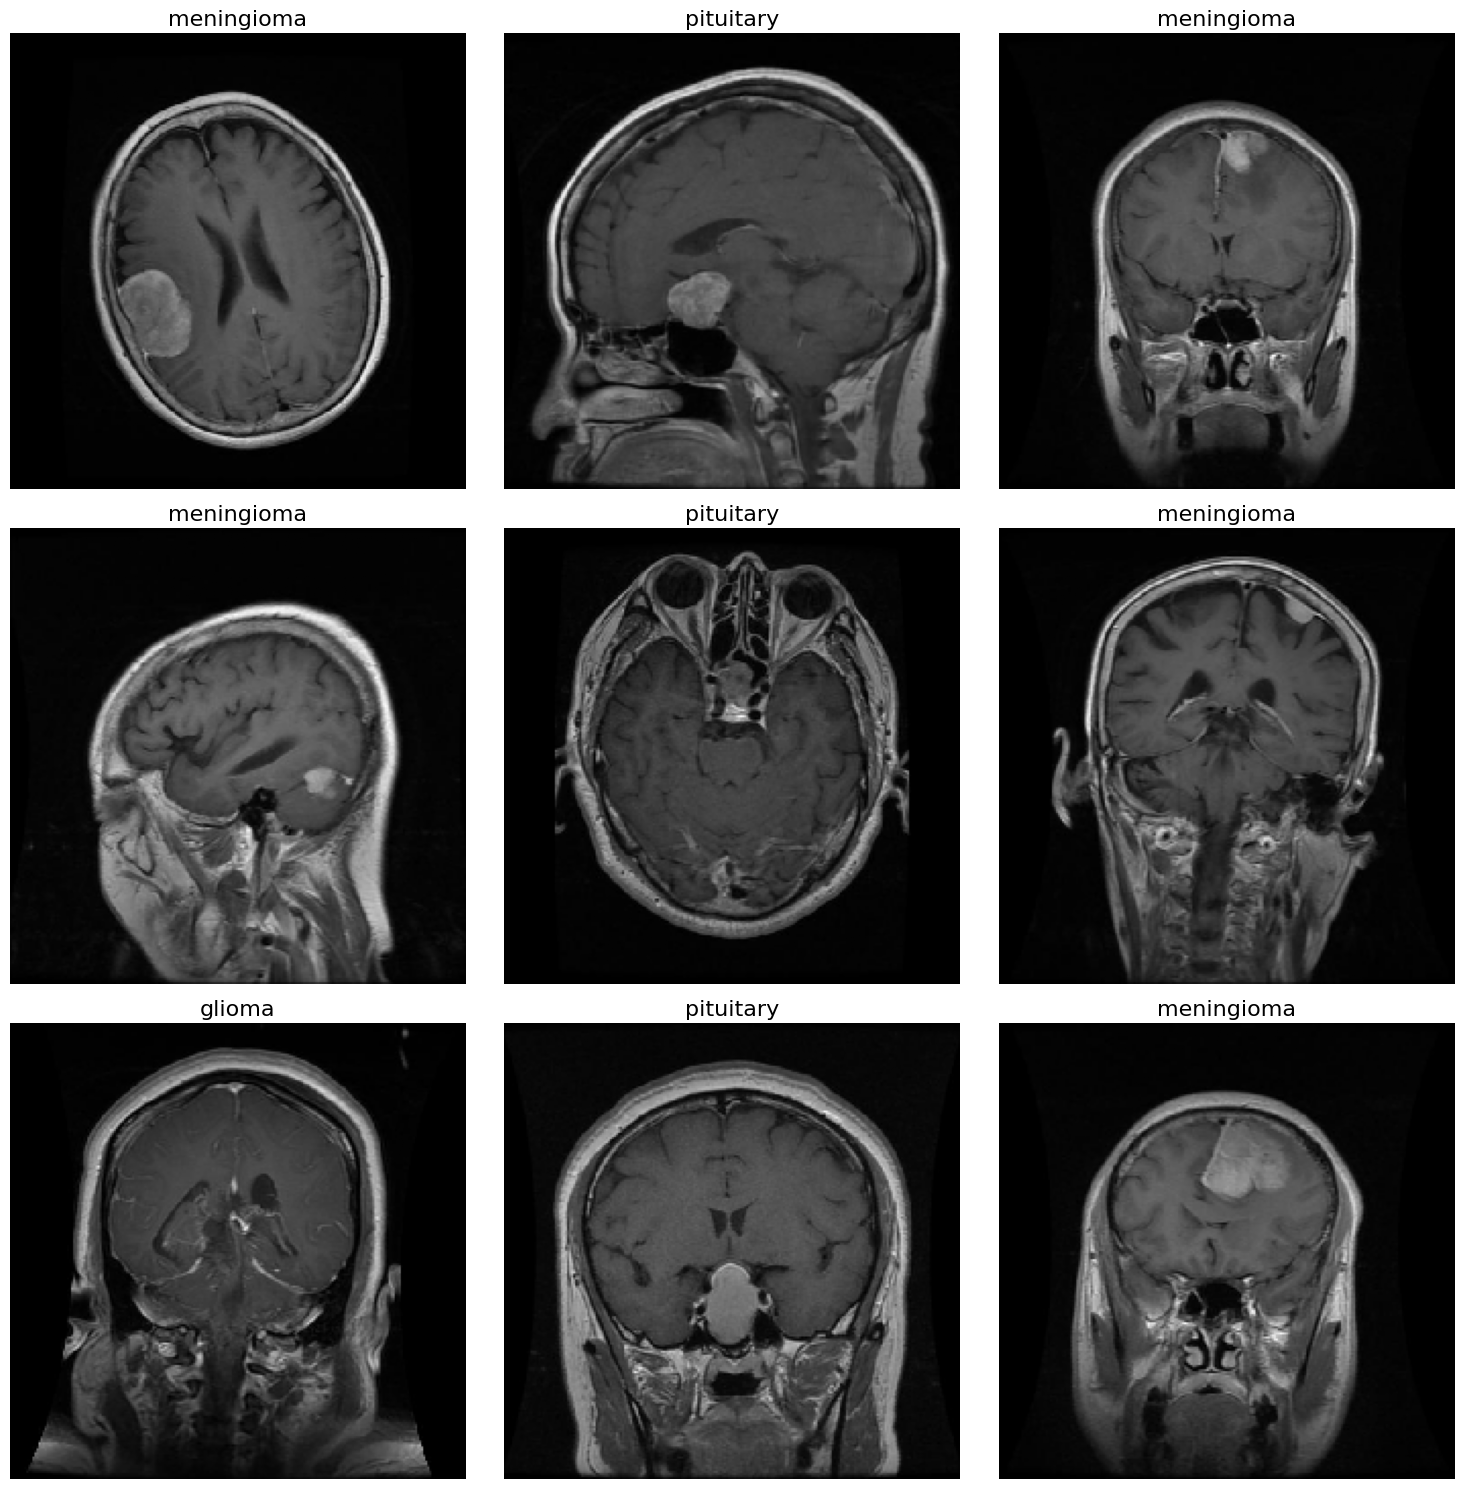

In [ ]:
# Definimos un diccionario: {'class': index}
g_dict = train_gen.class_indices
# Definimos la lista de keys del diccionario con las categorías que tenemos
classes = list(g_dict.keys())

# Seleccionamos un N muestras siendo N el barch size
images, labels = next(train_gen)

# Definimos el tamaño del gráfico
plt.figure(figsize= (15, 15))

# Mostramos por pantalla 9 ejemplos de imágenes junto a su categoría
for i in range(9):
    plt.subplot(3, 3, i + 1)
    # escalamos la imagen (0 - 255)
    image = images[i] / 255
    plt.imshow(image)
    # nos quedamos con el índice
    index = np.argmax(labels[i])
    # nos quedamos con la categoría
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Estructura del modelo**

A continuación vamos a construir un modelo de red neuronal convolucional simple utilizando la API secuencial de Keras, que consiste en capas de convolución, max pooling, aplanado y capas totalmente conectadas para la clasificación de imágenes.

In [ ]:
# Especificamos las características del modelo

# Tamaño de las imágenes
img_size = (224, 224)

# Número de canales (son 3 para imágenes RGB)
channels = 3

# Definimos el tamaño de las imágnes como 224x224x3
img_shape = (img_size[0], img_size[1], channels)

# Definimos el número de categorías (4)
class_count = len(list(train_gen.class_indices.keys()))

# model = Sequential(): Crea un modelo secuencial de Keras,
# que es un tipo de modelo que se construye agregando capas secuencialmente.
model = Sequential()

# Añade una capa de convolución al modelo.
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))

# Añade una capa de max pooling al modelo.
# Esta capa reduce la resolución espacial de la entrada mediante la reducción de las dimensiones de píxeles.
model.add(MaxPooling2D())

# Añade una capa de convolución al modelo
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
# Añade una capa de reducción máxima (max pooling) al modelo.
model.add(MaxPooling2D())

# Añade una capa de aplanado (flatten) al modelo.
# Esta capa convierte los datos en un vector unidimensional para poder conectarlo a una capa totalmente conectada.
model.add(Flatten())

# Añade más capas totalmente conectadas con función de activación ReLU para introducir no linealidad en la red.
model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))

# Añade la capa de salida al modelo.
# Esta es una capa totalmente conectada con un número de neuronas igual al número de clases en el problema.
# La función de activación softmax se utiliza para generar probabilidades para cada clase.
model.add(Dense(class_count, activation = "softmax"))


In [ ]:
# El método compile configura el modelo para el entrenamiento especificando el optimizador (Adam),
# la función de pérdida y las métricas de evaluación que se utilizarán durante el proceso de entrenamiento.
# Esto prepara el modelo para ser entrenado utilizando los datos proporcionados.
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

# Mostramos un resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                1

**Entrenamiento del modelo**

In [ ]:
# Definimos el número de epochs para el entrenamiento
# epoch: época es una unidad de medida utilizada para cuantificar el progreso
# del entrenamiento de un modelo durante el proceso de aprendizaje automático,
# representando una sola pasada completa a través de todo el conjunto de datos de entrenamiento.
# Si se configura el número de épocas en 10, el modelo verá todas las muestras
# de entrenamiento 10 veces en total durante el proceso de entrenamiento.
epochs = 10

# Entrenamos el modelo utilizando los generadores de flujo de datos train_gen y valid_gen durante un número especificado de epochs.
history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1404s 4s/step - accuracy: 0.6656 - loss: 39.2459 - val_accuracy: 0.8763 - val_loss: 0.3635
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 550s 2s/step - accuracy: 0.9550 - loss: 0.1757 - val_accuracy: 0.9298 - val_loss: 0.2408
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.9880 - loss: 0.0568 - val_accuracy: 0.9466 - val_loss: 0.1756
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.9972 - loss: 0.0224 - val_accuracy: 0.9573 - val_loss: 0.1790
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.9977 - loss: 0.0153 - val_accuracy: 0.9557 - val_loss: 0.2321
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.9996 - loss: 0.0038 - val_accuracy: 0.9496 - val_loss: 0.2196
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.9999 - loss: 0.0037 - val_accuracy: 0.9573 - val_loss: 0.2483
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.9998 - loss: 9.9399e-04 - va

**Mostramos la performance del modelo**

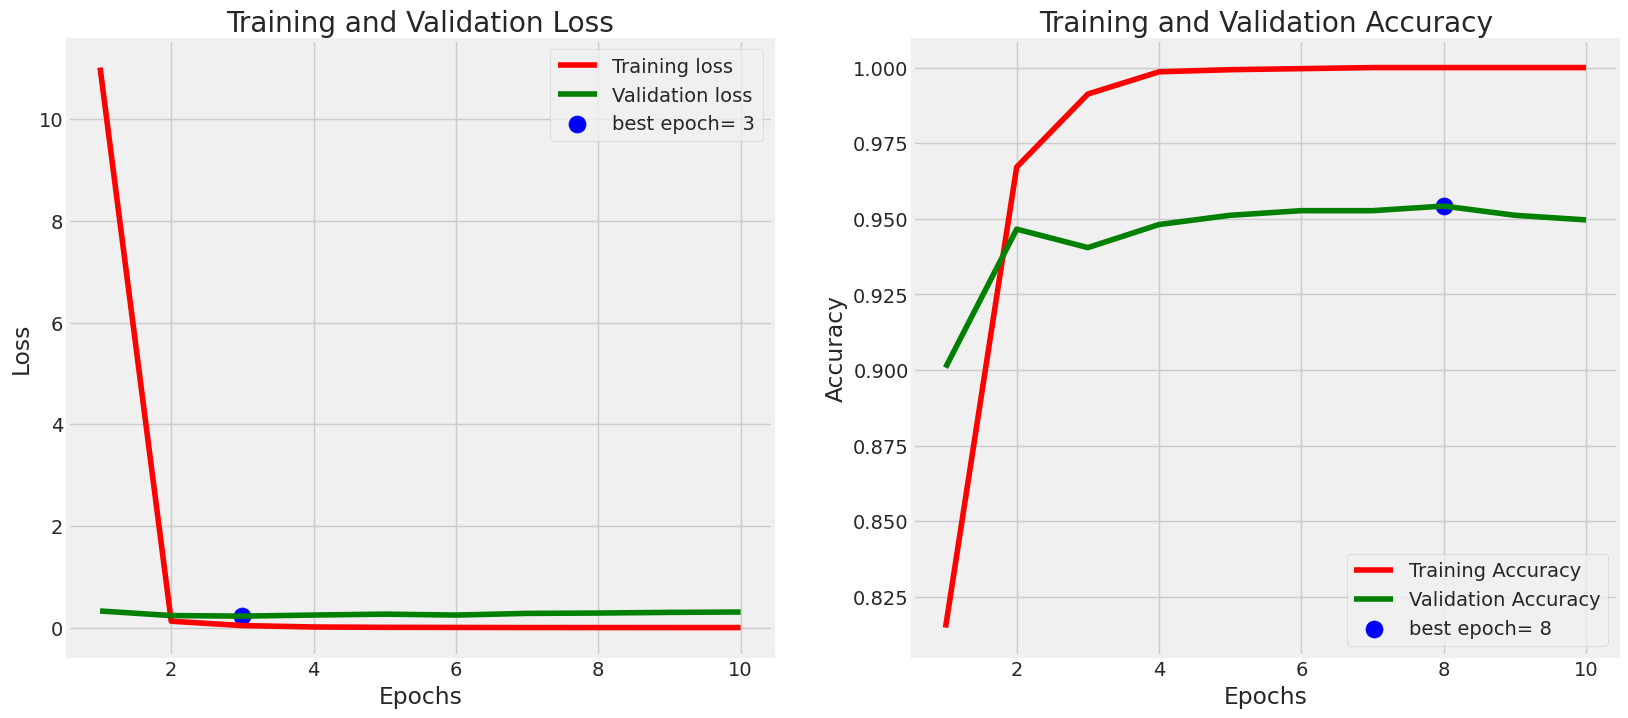

In [ ]:
# Definimos las variables que queremos mostrar
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Graficamos la evolución de las métricas en las distintas epochs
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluación del modelo**

In [ ]:
# Evaluamos el rendimiento del modelo en los conjuntos de datos de entrenamiento, validación y prueba
# El método evaluate devuelve una lista de valores que representan la pérdida (loss) y
# las métricas del modelo en el conjunto de datos especificado.
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

# Mostramos los resultados
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 198s 5s/step - loss: 0.1782 - accuracy: 0.9634
Train Loss:  5.9009460528614e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.3057658076286316
Validation Accuracy:  0.9496183395385742
--------------------
Test Loss:  0.17824864387512207
Test Accuracy:  0.9634146094322205


# **Predicciones**

In [ ]:
# Obtenemos las predicciones del conjunto de test
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 20s 488ms/step


**Resultados**

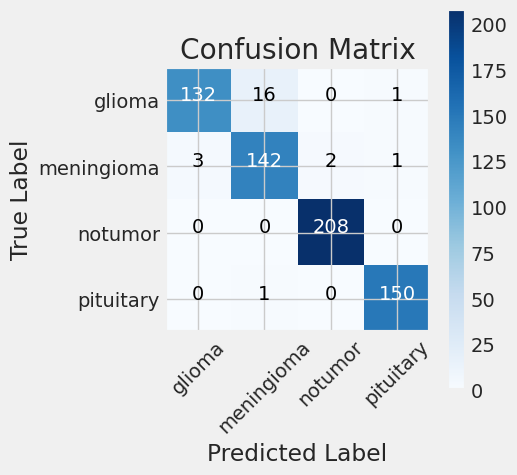

In [ ]:
# Nos quedamos con las categorías (clases)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Obtenemos la matriz de confusión
cm = confusion_matrix(test_gen.classes, y_pred)

# Mostramos la matriz de confusión de manera gráfica
plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Especificamos las etiquetas de los ejes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

# Dependiendo del color de la celda, ponemos el texto en blanco o negro
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


# Especificamos los títulos
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Mostramos el gráfico
plt.show()

In [ ]:
# Mostramos la tabla de las métricas
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.98      0.89      0.93       149
  meningioma       0.89      0.96      0.93       148
     notumor       0.99      1.00      1.00       208
   pituitary       0.99      0.99      0.99       151

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656



In [ ]:
# Guardamos el modelo
model.save('Brain Tumor.h5')